# Simulating Options Pricing with Powerlaw Returns

This notebook explores option pricing when the underlying asset returns follow a powerlaw (heavy-tailed) distribution, rather than the normal distribution assumed in Black-Scholes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import levy_stable
from ipywidgets import interact, FloatSlider, IntSlider, Output
from IPython.display import display, Markdown

# Levy-stable Distribution and Powerlaw Models

The **Levy-stable distribution** is a family of probability distributions that generalizes the normal (Gaussian) distribution to allow for heavy tails and skewness. Unlike the normal distribution, Levy-stable distributions can have infinite variance and even infinite mean, depending on their parameters. This makes them suitable for modeling phenomena with large, unpredictable jumps—such as financial returns in markets with extreme events.

**Parameters:**
- $\alpha$ (stability index, $0 < \alpha \leq 2$): Controls the tail thickness. Lower $\alpha$ means heavier tails. $\alpha=2$ is the normal distribution; $\alpha=1$ is the Cauchy distribution.
- $\beta$ (skewness, $-1 \leq \beta \leq 1$): Controls asymmetry. $\beta=0$ is symmetric.
- $\text{scale}$: Controls the scale (similar to standard deviation for normal).
- $\text{location}$: The central location (set to 0 in our simulation).

**Relation to Powerlaw:**
Levy-stable distributions with $\alpha < 2$ exhibit powerlaw tails, meaning the probability of extreme returns decays as a power of the return size: $P(|x| > X) \sim X^{-\alpha}$. This property makes them a canonical model for heavy-tailed, powerlaw-distributed returns in finance, capturing the higher likelihood of large price moves compared to the normal distribution.

In this notebook, we use the Levy-stable distribution to generate returns for simulating price paths with realistic, heavy-tailed risk.

## Simulating and Plotting the Distribution of Returns

Before simulating the price paths, we simulate and plot the distribution of returns from the Levy-stable distribution.

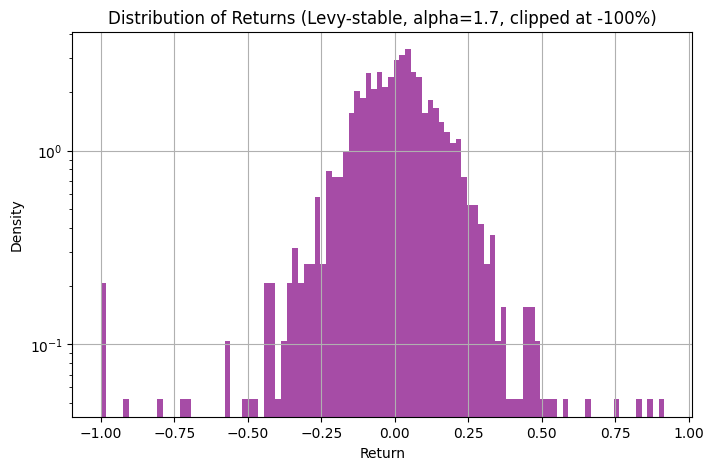

In [22]:
# Simulate and plot distribution of returns from Levy-stable distribution, clipped at -100%
alpha, beta, scale, steps = 1.7, 0, 0.1, 1000
returns = levy_stable.rvs(alpha, beta, scale=scale, size=steps)
returns = np.clip(returns, -1, None)  # Clip returns at -100%
plt.figure(figsize=(8,5))
plt.hist(returns, bins=100, density=True, alpha=0.7, color='purple')
plt.title('Distribution of Returns (Levy-stable, alpha=1.7, clipped at -100%)')
plt.xlabel('Return')
plt.ylabel('Density')
plt.yscale('log')
plt.grid(True)
plt.show()

## Simulating Price Paths with Powerlaw Returns

We use a Levy-stable distribution to generate heavy-tailed returns, simulating more extreme price movements than normality.

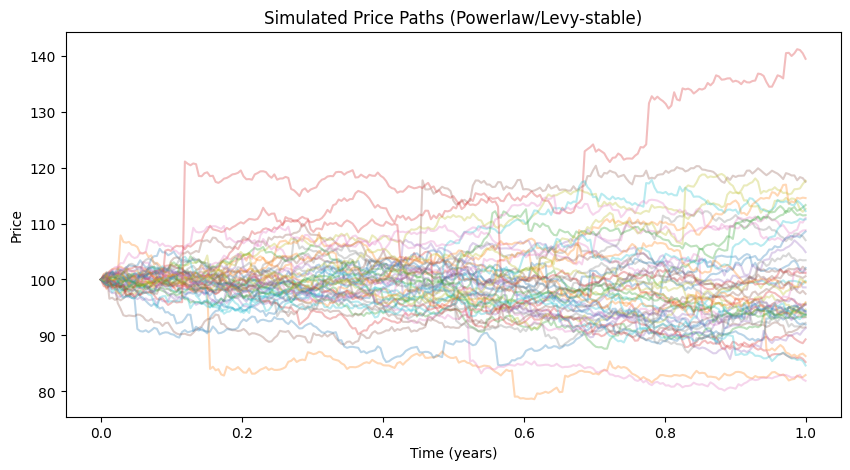

In [23]:
def simulate_powerlaw_paths(S0=100, alpha=1.7, beta=0, scale=0.05, T=1, steps=252, n_paths=50):
    dt = T / steps
    t = np.linspace(0, T, steps+1)
    paths = np.zeros((n_paths, steps+1))
    paths[:, 0] = S0
    for i in range(n_paths):
        # Levy-stable returns
        returns = levy_stable.rvs(alpha, beta, scale=scale*np.sqrt(dt), size=steps)
        increments = returns
        paths[i, 1:] = S0 * np.exp(np.cumsum(increments))
    return t, paths

t, paths = simulate_powerlaw_paths(n_paths=50)
plt.figure(figsize=(10,5))
plt.plot(t, paths.T, alpha=0.3)
plt.title('Simulated Price Paths (Powerlaw/Levy-stable)')
plt.xlabel('Time (years)')
plt.ylabel('Price')
plt.show()

## Monte Carlo Option Pricing on Powerlaw Paths

Estimate the price of a European call option by simulating many powerlaw price paths and averaging the discounted payoff at expiry.

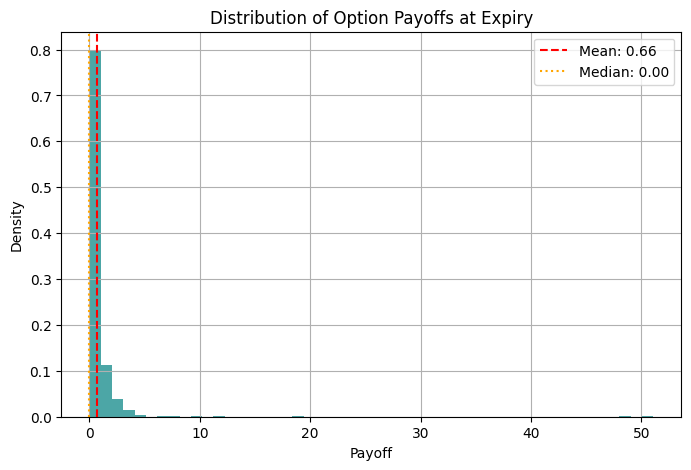

Monte Carlo option price (powerlaw): 0.63


In [36]:
def monte_carlo_option_price_powerlaw(S0=9.81, K=9.81, r=0.04, alpha=1.7, beta=0, scale=0.05, T=1, steps=252, n_paths=1000, option_type='call', plot_expiry_payoff=False):
    t, paths = simulate_powerlaw_paths(S0, alpha, beta, scale, T, steps, n_paths)
    S_T = paths[:, -1]
    if option_type == 'call':
        payoffs = np.maximum(S_T - K, 0)
    else:
        payoffs = np.maximum(K - S_T, 0)
    price = np.exp(-r * T) * np.mean(payoffs)
    if plot_expiry_payoff:
        plt.figure(figsize=(8,5))
        plt.hist(payoffs, bins=50, density=True, alpha=0.7, color='teal')
        mean_payoff = np.mean(payoffs)
        median_payoff = np.median(payoffs)
        plt.axvline(mean_payoff, color='red', linestyle='--', label=f'Mean: {mean_payoff:.2f}')
        plt.axvline(median_payoff, color='orange', linestyle=':', label=f'Median: {median_payoff:.2f}')
        plt.title('Distribution of Option Payoffs at Expiry')
        plt.xlabel('Payoff')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.show()
    return price

# Example usage:
price = monte_carlo_option_price_powerlaw(plot_expiry_payoff=True)
print(f"Monte Carlo option price (powerlaw): {price:.2f}")